In [1]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os
from accelerate import Accelerator

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Variables
model_name = 'meta-llama/Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/division_non/non.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/division_non/non.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'

/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

In [4]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')  # Initialize the best accuracy to negative infinity
    best_f1 = -float('inf')  # Initialize the best F1-score to negative infinity
    best_model_state = None  # Store the state of the best model
    best_epoch = 0  # Track the epoch with the best accuracy
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # Calculate F1-score
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Check if the current model is the best based on F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Best Model was saved at epoch {best_epoch} with F1-score {best_f1:.4f} and accuracy {best_accuracy * 100:.2f}%")
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


accelerator = Accelerator()
model, non_infringement_outputs, infringement_outputs = accelerator.prepare(model, non_infringement_outputs, infringement_outputs)

/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 104/104 [00:10<00:00,  9.80it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 45/45 [00:04<00:00,  9.38it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")


Data successfully split into training and test sets.


Training Epochs:   1%|          | 20/2000 [00:00<00:39, 50.24it/s]

Epoch 10/2000, Loss: 5.3725
Test Accuracy at Epoch 10: 35.29%
Test F1-score at Epoch 10: 0.2667
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.29      0.78      0.42        36
non_infringement       0.64      0.17      0.27        83

        accuracy                           0.35       119
       macro avg       0.46      0.47      0.34       119
    weighted avg       0.53      0.35      0.31       119

New best model saved with F1-score 0.2667 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.29      0.78      0.42        36
non_infringement       0.64      0.17      0.27        83

        accuracy                           0.35       119
       macro avg       0.46      0.47      0.34       119
    weighted avg       0.53      0.35      0.31       119

Epoch 20/2000, Loss: 0.4503
Test Accuracy at Epoch 20: 67.23%
Test F1-sco

Training Epochs:   2%|▏         | 41/2000 [00:00<00:32, 60.67it/s]

Epoch 30/2000, Loss: 0.4895
Test Accuracy at Epoch 30: 71.43%
Test F1-score at Epoch 30: 0.8265
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.67      0.11      0.19        36
non_infringement       0.72      0.98      0.83        83

        accuracy                           0.71       119
       macro avg       0.69      0.54      0.51       119
    weighted avg       0.70      0.71      0.63       119

New best model saved with F1-score 0.8265 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.67      0.11      0.19        36
non_infringement       0.72      0.98      0.83        83

        accuracy                           0.71       119
       macro avg       0.69      0.54      0.51       119
    weighted avg       0.70      0.71      0.63       119

Epoch 40/2000, Loss: 0.4849
Test Accuracy at Epoch 40: 68.07%
Test F1-sco

Training Epochs:   3%|▎         | 56/2000 [00:00<00:29, 65.61it/s]

Epoch 50/2000, Loss: 0.4708
Test Accuracy at Epoch 50: 69.75%
Test F1-score at Epoch 50: 0.8144
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.50      0.11      0.18        36
non_infringement       0.71      0.95      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.53      0.50       119
    weighted avg       0.65      0.70      0.62       119

Epoch 60/2000, Loss: 0.4271
Test Accuracy at Epoch 60: 70.59%
Test F1-score at Epoch 60: 0.8205
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.57      0.11      0.19        36
non_infringement       0.71      0.96      0.82        83

        accuracy                           0.71       119
       macro avg       0.64      0.54      0.50       119
    weighted avg       0.67      0.71      0.63       119



Training Epochs:   4%|▍         | 78/2000 [00:01<00:28, 66.81it/s]

Epoch 70/2000, Loss: 0.3840
Test Accuracy at Epoch 70: 70.59%
Test F1-score at Epoch 70: 0.8205
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.57      0.11      0.19        36
non_infringement       0.71      0.96      0.82        83

        accuracy                           0.71       119
       macro avg       0.64      0.54      0.50       119
    weighted avg       0.67      0.71      0.63       119

Epoch 80/2000, Loss: 0.3083
Test Accuracy at Epoch 80: 70.59%
Test F1-score at Epoch 80: 0.8168
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.55      0.17      0.26        36
non_infringement       0.72      0.94      0.82        83

        accuracy                           0.71       119
       macro avg       0.63      0.55      0.54       119
    weighted avg       0.67      0.71      0.65       119



Training Epochs:   5%|▌         | 100/2000 [00:01<00:28, 66.92it/s]

Epoch 90/2000, Loss: 0.2701
Test Accuracy at Epoch 90: 73.11%
Test F1-score at Epoch 90: 0.8202
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.58      0.39      0.47        36
non_infringement       0.77      0.88      0.82        83

        accuracy                           0.73       119
       macro avg       0.68      0.63      0.64       119
    weighted avg       0.71      0.73      0.71       119

Epoch 100/2000, Loss: 0.2276
Test Accuracy at Epoch 100: 71.43%
Test F1-score at Epoch 100: 0.8090
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.54      0.36      0.43        36
non_infringement       0.76      0.87      0.81        83

        accuracy                           0.71       119
       macro avg       0.65      0.61      0.62       119
    weighted avg       0.69      0.71      0.70       119



Training Epochs:   6%|▌         | 122/2000 [00:01<00:27, 68.25it/s]

Epoch 110/2000, Loss: 0.2192
Test Accuracy at Epoch 110: 68.91%
Test F1-score at Epoch 110: 0.8021
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.47      0.19      0.27        36
non_infringement       0.72      0.90      0.80        83

        accuracy                           0.69       119
       macro avg       0.59      0.55      0.54       119
    weighted avg       0.64      0.69      0.64       119

Epoch 120/2000, Loss: 0.1900
Test Accuracy at Epoch 120: 68.07%
Test F1-score at Epoch 120: 0.7791
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.47      0.39      0.42        36
non_infringement       0.75      0.81      0.78        83

        accuracy                           0.68       119
       macro avg       0.61      0.60      0.60       119
    weighted avg       0.67      0.68      0.67       119



Training Epochs:   7%|▋         | 138/2000 [00:02<00:26, 70.15it/s]

Epoch 130/2000, Loss: 0.3269
Test Accuracy at Epoch 130: 62.18%
Test F1-score at Epoch 130: 0.7134
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.40      0.50      0.44        36
non_infringement       0.76      0.67      0.71        83

        accuracy                           0.62       119
       macro avg       0.58      0.59      0.58       119
    weighted avg       0.65      0.62      0.63       119

Epoch 140/2000, Loss: 0.1328
Test Accuracy at Epoch 140: 63.87%
Test F1-score at Epoch 140: 0.7296
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.42      0.50      0.46        36
non_infringement       0.76      0.70      0.73        83

        accuracy                           0.64       119
       macro avg       0.59      0.60      0.59       119
    weighted avg       0.66      0.64      0.65       119



Training Epochs:   8%|▊         | 153/2000 [00:02<00:27, 67.38it/s]

Epoch 150/2000, Loss: 0.2170
Test Accuracy at Epoch 150: 67.23%
Test F1-score at Epoch 150: 0.7692
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.45      0.42      0.43        36
non_infringement       0.76      0.78      0.77        83

        accuracy                           0.67       119
       macro avg       0.61      0.60      0.60       119
    weighted avg       0.66      0.67      0.67       119

Epoch 160/2000, Loss: 0.1303
Test Accuracy at Epoch 160: 69.75%
Test F1-score at Epoch 160: 0.8085


Training Epochs:   8%|▊         | 167/2000 [00:02<00:29, 61.53it/s]

Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.50      0.19      0.28        36
non_infringement       0.72      0.92      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.54       119
    weighted avg       0.66      0.70      0.65       119

Epoch 170/2000, Loss: 0.1149
Test Accuracy at Epoch 170: 68.91%
Test F1-score at Epoch 170: 0.8021
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.47      0.19      0.27        36
non_infringement       0.72      0.90      0.80        83

        accuracy                           0.69       119
       macro avg       0.59      0.55      0.54       119
    weighted avg       0.64      0.69      0.64       119



Training Epochs:   9%|▉         | 187/2000 [00:03<00:34, 52.23it/s]

Epoch 180/2000, Loss: 0.0862
Test Accuracy at Epoch 180: 68.07%
Test F1-score at Epoch 180: 0.7979
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.43      0.17      0.24        36
non_infringement       0.71      0.90      0.80        83

        accuracy                           0.68       119
       macro avg       0.57      0.54      0.52       119
    weighted avg       0.63      0.68      0.63       119

Epoch 190/2000, Loss: 0.0635


Training Epochs:  10%|█         | 201/2000 [00:03<00:30, 58.64it/s]

Test Accuracy at Epoch 190: 68.07%
Test F1-score at Epoch 190: 0.7935
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119

Epoch 200/2000, Loss: 0.0523
Test Accuracy at Epoch 200: 68.91%
Test F1-score at Epoch 200: 0.8021
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.47      0.19      0.27        36
non_infringement       0.72      0.90      0.80        83

        accuracy                           0.69       119
       macro avg       0.59      0.55      0.54       119
    weighted avg       0.64      0.69      0.64       119



Training Epochs:  11%|█         | 223/2000 [00:03<00:27, 64.77it/s]

Epoch 210/2000, Loss: 0.0440
Test Accuracy at Epoch 210: 68.91%
Test F1-score at Epoch 210: 0.8021
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.47      0.19      0.27        36
non_infringement       0.72      0.90      0.80        83

        accuracy                           0.69       119
       macro avg       0.59      0.55      0.54       119
    weighted avg       0.64      0.69      0.64       119

Epoch 220/2000, Loss: 0.0353
Test Accuracy at Epoch 220: 68.07%
Test F1-score at Epoch 220: 0.7935
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119



Training Epochs:  12%|█▏        | 238/2000 [00:03<00:26, 67.55it/s]

Epoch 230/2000, Loss: 0.0307
Test Accuracy at Epoch 230: 68.91%
Test F1-score at Epoch 230: 0.8000
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119

Epoch 240/2000, Loss: 0.0273
Test Accuracy at Epoch 240: 68.91%
Test F1-score at Epoch 240: 0.8000
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119



Training Epochs:  13%|█▎        | 260/2000 [00:04<00:26, 66.17it/s]

Epoch 250/2000, Loss: 0.0247
Test Accuracy at Epoch 250: 68.91%
Test F1-score at Epoch 250: 0.8000
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119

Epoch 260/2000, Loss: 0.0227
Test Accuracy at Epoch 260: 68.91%
Test F1-score at Epoch 260: 0.8000
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119



Training Epochs:  14%|█▍        | 282/2000 [00:04<00:26, 65.07it/s]

Epoch 270/2000, Loss: 0.0210
Test Accuracy at Epoch 270: 68.91%
Test F1-score at Epoch 270: 0.8000
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119

Epoch 280/2000, Loss: 0.0196
Test Accuracy at Epoch 280: 68.91%
Test F1-score at Epoch 280: 0.8000
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119



Training Epochs:  15%|█▍        | 296/2000 [00:04<00:25, 65.81it/s]

Epoch 290/2000, Loss: 0.0184
Test Accuracy at Epoch 290: 68.91%
Test F1-score at Epoch 290: 0.8000
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119

Epoch 300/2000, Loss: 0.0173
Test Accuracy at Epoch 300: 68.07%
Test F1-score at Epoch 300: 0.7935
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119



Training Epochs:  16%|█▌        | 318/2000 [00:05<00:25, 66.64it/s]

Epoch 310/2000, Loss: 0.0163
Test Accuracy at Epoch 310: 68.07%
Test F1-score at Epoch 310: 0.7935
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119

Epoch 320/2000, Loss: 0.0166
Test Accuracy at Epoch 320: 68.91%
Test F1-score at Epoch 320: 0.8000
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119



Training Epochs:  17%|█▋        | 340/2000 [00:05<00:25, 64.13it/s]

Epoch 330/2000, Loss: 0.0159
Test Accuracy at Epoch 330: 68.91%
Test F1-score at Epoch 330: 0.8000
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119

Epoch 340/2000, Loss: 0.0154
Test Accuracy at Epoch 340: 68.07%
Test F1-score at Epoch 340: 0.7935
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119



Training Epochs:  18%|█▊        | 360/2000 [00:05<00:30, 54.22it/s]

Epoch 350/2000, Loss: 0.0149
Test Accuracy at Epoch 350: 68.07%
Test F1-score at Epoch 350: 0.7935
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119

Epoch 360/2000, Loss: 0.0144
Test Accuracy at Epoch 360: 68.07%
Test F1-score at Epoch 360: 0.7935
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119



Training Epochs:  19%|█▉        | 381/2000 [00:06<00:27, 59.14it/s]

Epoch 370/2000, Loss: 0.0139
Test Accuracy at Epoch 370: 68.07%
Test F1-score at Epoch 370: 0.7935
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119

Epoch 380/2000, Loss: 0.0135
Test Accuracy at Epoch 380: 68.07%
Test F1-score at Epoch 380: 0.7935
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119



Training Epochs:  20%|█▉        | 397/2000 [00:06<00:24, 66.23it/s]

Epoch 390/2000, Loss: 0.0132
Test Accuracy at Epoch 390: 67.23%
Test F1-score at Epoch 390: 0.7869
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.42      0.22      0.29        36
non_infringement       0.72      0.87      0.79        83

        accuracy                           0.67       119
       macro avg       0.57      0.54      0.54       119
    weighted avg       0.63      0.67      0.64       119

Epoch 400/2000, Loss: 0.0128
Test Accuracy at Epoch 400: 67.23%
Test F1-score at Epoch 400: 0.7869
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.42      0.22      0.29        36
non_infringement       0.72      0.87      0.79        83

        accuracy                           0.67       119
       macro avg       0.57      0.54      0.54       119
    weighted avg       0.63      0.67      0.64       119



Training Epochs:  21%|██        | 421/2000 [00:06<00:22, 70.56it/s]

Epoch 410/2000, Loss: 0.0125
Test Accuracy at Epoch 410: 67.23%
Test F1-score at Epoch 410: 0.7869
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.42      0.22      0.29        36
non_infringement       0.72      0.87      0.79        83

        accuracy                           0.67       119
       macro avg       0.57      0.54      0.54       119
    weighted avg       0.63      0.67      0.64       119

Epoch 420/2000, Loss: 0.0122
Test Accuracy at Epoch 420: 67.23%
Test F1-score at Epoch 420: 0.7869
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.42      0.22      0.29        36
non_infringement       0.72      0.87      0.79        83

        accuracy                           0.67       119
       macro avg       0.57      0.54      0.54       119
    weighted avg       0.63      0.67      0.64       119



Training Epochs:  22%|██▏       | 437/2000 [00:06<00:22, 70.11it/s]

Epoch 430/2000, Loss: 0.0120
Test Accuracy at Epoch 430: 68.07%
Test F1-score at Epoch 430: 0.7935
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119

Epoch 440/2000, Loss: 0.0118
Test Accuracy at Epoch 440: 68.07%
Test F1-score at Epoch 440: 0.7935
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119



Training Epochs:  23%|██▎       | 460/2000 [00:07<00:23, 66.05it/s]

Epoch 450/2000, Loss: 0.0116
Test Accuracy at Epoch 450: 68.07%
Test F1-score at Epoch 450: 0.7935
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119

Epoch 460/2000, Loss: 0.0114
Test Accuracy at Epoch 460: 68.07%
Test F1-score at Epoch 460: 0.7935
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119



Training Epochs:  24%|██▍       | 476/2000 [00:07<00:21, 69.84it/s]

Epoch 470/2000, Loss: 0.0112
Test Accuracy at Epoch 470: 67.23%
Test F1-score at Epoch 470: 0.7892
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.41      0.19      0.26        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.67       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.67      0.63       119

Epoch 480/2000, Loss: 0.0111
Test Accuracy at Epoch 480: 67.23%
Test F1-score at Epoch 480: 0.7892
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.41      0.19      0.26        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.67       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.67      0.63       119



Training Epochs:  25%|██▍       | 499/2000 [00:07<00:21, 69.58it/s]

Epoch 490/2000, Loss: 0.0109
Test Accuracy at Epoch 490: 67.23%
Test F1-score at Epoch 490: 0.7892
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.41      0.19      0.26        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.67       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.67      0.63       119

Epoch 500/2000, Loss: 0.0108
Test Accuracy at Epoch 500: 67.23%
Test F1-score at Epoch 500: 0.7892
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.41      0.19      0.26        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.67       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.67      0.63       119



Training Epochs:  26%|██▌       | 520/2000 [00:08<00:22, 66.86it/s]

Epoch 510/2000, Loss: 0.0107
Test Accuracy at Epoch 510: 67.23%
Test F1-score at Epoch 510: 0.7892
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.41      0.19      0.26        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.67       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.67      0.63       119

Epoch 520/2000, Loss: 0.0106
Test Accuracy at Epoch 520: 68.07%
Test F1-score at Epoch 520: 0.7957
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.44      0.19      0.27        36
non_infringement       0.72      0.89      0.80        83

        accuracy                           0.68       119
       macro avg       0.58      0.54      0.53       119
    weighted avg       0.63      0.68      0.64       119



Training Epochs:  27%|██▋       | 542/2000 [00:08<00:21, 69.23it/s]

Epoch 530/2000, Loss: 0.0105
Test Accuracy at Epoch 530: 68.07%
Test F1-score at Epoch 530: 0.7957
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.44      0.19      0.27        36
non_infringement       0.72      0.89      0.80        83

        accuracy                           0.68       119
       macro avg       0.58      0.54      0.53       119
    weighted avg       0.63      0.68      0.64       119

Epoch 540/2000, Loss: 0.0104
Test Accuracy at Epoch 540: 68.07%
Test F1-score at Epoch 540: 0.7957
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.44      0.19      0.27        36
non_infringement       0.72      0.89      0.80        83

        accuracy                           0.68       119
       macro avg       0.58      0.54      0.53       119
    weighted avg       0.63      0.68      0.64       119



Training Epochs:  28%|██▊       | 558/2000 [00:08<00:20, 70.06it/s]

Epoch 550/2000, Loss: 0.0103
Test Accuracy at Epoch 550: 68.07%
Test F1-score at Epoch 550: 0.7957
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.44      0.19      0.27        36
non_infringement       0.72      0.89      0.80        83

        accuracy                           0.68       119
       macro avg       0.58      0.54      0.53       119
    weighted avg       0.63      0.68      0.64       119

Epoch 560/2000, Loss: 0.0102
Test Accuracy at Epoch 560: 68.07%
Test F1-score at Epoch 560: 0.7957
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.44      0.19      0.27        36
non_infringement       0.72      0.89      0.80        83

        accuracy                           0.68       119
       macro avg       0.58      0.54      0.53       119
    weighted avg       0.63      0.68      0.64       119



Training Epochs:  29%|██▉       | 580/2000 [00:08<00:20, 68.38it/s]

Epoch 570/2000, Loss: 0.0102
Test Accuracy at Epoch 570: 68.07%
Test F1-score at Epoch 570: 0.7935
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119

Epoch 580/2000, Loss: 0.0101
Test Accuracy at Epoch 580: 68.07%
Test F1-score at Epoch 580: 0.7935
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119



Training Epochs:  30%|███       | 603/2000 [00:09<00:20, 69.45it/s]

Epoch 590/2000, Loss: 0.0100
Test Accuracy at Epoch 590: 68.07%
Test F1-score at Epoch 590: 0.7935
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119

Epoch 600/2000, Loss: 0.0100
Test Accuracy at Epoch 600: 68.07%
Test F1-score at Epoch 600: 0.7935
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119



Training Epochs:  31%|███       | 617/2000 [00:09<00:20, 69.12it/s]

Epoch 610/2000, Loss: 0.0099
Test Accuracy at Epoch 610: 68.07%
Test F1-score at Epoch 610: 0.7935
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119

Epoch 620/2000, Loss: 0.0098
Test Accuracy at Epoch 620: 68.07%
Test F1-score at Epoch 620: 0.7935
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119



Training Epochs:  32%|███▏      | 639/2000 [00:09<00:19, 70.23it/s]

Epoch 630/2000, Loss: 0.0098
Test Accuracy at Epoch 630: 68.07%
Test F1-score at Epoch 630: 0.7935
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119

Epoch 640/2000, Loss: 0.0097
Test Accuracy at Epoch 640: 68.07%
Test F1-score at Epoch 640: 0.7935
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119



Training Epochs:  33%|███▎      | 662/2000 [00:10<00:19, 68.32it/s]

Epoch 650/2000, Loss: 0.0097
Test Accuracy at Epoch 650: 68.91%
Test F1-score at Epoch 650: 0.8000
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119

Epoch 660/2000, Loss: 0.0096
Test Accuracy at Epoch 660: 68.91%
Test F1-score at Epoch 660: 0.8000
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119



Training Epochs:  34%|███▍      | 678/2000 [00:10<00:18, 70.86it/s]

Epoch 670/2000, Loss: 0.0096
Test Accuracy at Epoch 670: 68.91%
Test F1-score at Epoch 670: 0.8000
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119

Epoch 680/2000, Loss: 0.0096
Test Accuracy at Epoch 680: 68.91%
Test F1-score at Epoch 680: 0.8000
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119



Training Epochs:  35%|███▌      | 701/2000 [00:10<00:18, 68.52it/s]

Epoch 690/2000, Loss: 0.0095
Test Accuracy at Epoch 690: 68.91%
Test F1-score at Epoch 690: 0.8000
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119

Epoch 700/2000, Loss: 0.0095
Test Accuracy at Epoch 700: 68.91%
Test F1-score at Epoch 700: 0.8000
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119



Training Epochs:  36%|███▌      | 717/2000 [00:10<00:17, 71.42it/s]

Epoch 710/2000, Loss: 0.0095
Test Accuracy at Epoch 710: 68.91%
Test F1-score at Epoch 710: 0.8000
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119

Epoch 720/2000, Loss: 0.0094
Test Accuracy at Epoch 720: 68.91%
Test F1-score at Epoch 720: 0.8000
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119



Training Epochs:  37%|███▋      | 741/2000 [00:11<00:18, 69.01it/s]

Epoch 730/2000, Loss: 0.0094
Test Accuracy at Epoch 730: 68.91%
Test F1-score at Epoch 730: 0.8000
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119

Epoch 740/2000, Loss: 0.0093
Test Accuracy at Epoch 740: 68.91%
Test F1-score at Epoch 740: 0.8000
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119



Training Epochs:  38%|███▊      | 764/2000 [00:11<00:18, 67.94it/s]

Epoch 750/2000, Loss: 0.0093
Test Accuracy at Epoch 750: 68.91%
Test F1-score at Epoch 750: 0.8000
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119

Epoch 760/2000, Loss: 0.0093
Test Accuracy at Epoch 760: 68.91%
Test F1-score at Epoch 760: 0.8000
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119



Training Epochs:  39%|███▉      | 780/2000 [00:11<00:17, 71.39it/s]

Epoch 770/2000, Loss: 0.0093
Test Accuracy at Epoch 770: 68.91%
Test F1-score at Epoch 770: 0.8000
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119

Epoch 780/2000, Loss: 0.0092
Test Accuracy at Epoch 780: 68.91%
Test F1-score at Epoch 780: 0.8000
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119



Training Epochs:  40%|███▉      | 797/2000 [00:12<00:16, 75.14it/s]

Epoch 790/2000, Loss: 0.0092
Test Accuracy at Epoch 790: 68.91%
Test F1-score at Epoch 790: 0.8000
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119

Epoch 800/2000, Loss: 0.0092
Test Accuracy at Epoch 800: 68.91%
Test F1-score at Epoch 800: 0.8000
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119



Training Epochs:  41%|████      | 821/2000 [00:12<00:15, 75.05it/s]

Epoch 810/2000, Loss: 0.0091
Test Accuracy at Epoch 810: 68.91%
Test F1-score at Epoch 810: 0.8000
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119

Epoch 820/2000, Loss: 0.0091
Test Accuracy at Epoch 820: 69.75%
Test F1-score at Epoch 820: 0.8065
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119



Training Epochs:  42%|████▏     | 839/2000 [00:12<00:15, 76.85it/s]

Epoch 830/2000, Loss: 0.0091
Test Accuracy at Epoch 830: 69.75%
Test F1-score at Epoch 830: 0.8065
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119

Epoch 840/2000, Loss: 0.0090
Test Accuracy at Epoch 840: 69.75%
Test F1-score at Epoch 840: 0.8065
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119



Training Epochs:  43%|████▎     | 863/2000 [00:12<00:14, 76.75it/s]

Epoch 850/2000, Loss: 0.0087
Test Accuracy at Epoch 850: 69.75%
Test F1-score at Epoch 850: 0.8065
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119

Epoch 860/2000, Loss: 0.0082
Test Accuracy at Epoch 860: 69.75%
Test F1-score at Epoch 860: 0.8065
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119



Training Epochs:  44%|████▍     | 880/2000 [00:13<00:14, 76.54it/s]

Epoch 870/2000, Loss: 0.0081
Test Accuracy at Epoch 870: 69.75%
Test F1-score at Epoch 870: 0.8065
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119

Epoch 880/2000, Loss: 0.0089
Test Accuracy at Epoch 880: 68.91%
Test F1-score at Epoch 880: 0.8000
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119



Training Epochs:  45%|████▌     | 905/2000 [00:13<00:14, 77.64it/s]

Epoch 890/2000, Loss: 0.0089
Test Accuracy at Epoch 890: 69.75%
Test F1-score at Epoch 890: 0.8065
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119

Epoch 900/2000, Loss: 0.0088
Test Accuracy at Epoch 900: 68.91%
Test F1-score at Epoch 900: 0.8000
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119



Training Epochs:  46%|████▌     | 921/2000 [00:13<00:13, 77.79it/s]

Epoch 910/2000, Loss: 0.0088
Test Accuracy at Epoch 910: 69.75%
Test F1-score at Epoch 910: 0.8065
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119

Epoch 920/2000, Loss: 0.0087
Test Accuracy at Epoch 920: 69.75%
Test F1-score at Epoch 920: 0.8065
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119



Training Epochs:  47%|████▋     | 939/2000 [00:13<00:13, 80.00it/s]

Epoch 930/2000, Loss: 0.0087
Test Accuracy at Epoch 930: 69.75%
Test F1-score at Epoch 930: 0.8065
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119

Epoch 940/2000, Loss: 0.0086
Test Accuracy at Epoch 940: 69.75%
Test F1-score at Epoch 940: 0.8065
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119



Training Epochs:  48%|████▊     | 964/2000 [00:14<00:13, 78.24it/s]

Epoch 950/2000, Loss: 0.0085
Test Accuracy at Epoch 950: 69.75%
Test F1-score at Epoch 950: 0.8065
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119

Epoch 960/2000, Loss: 0.0085
Test Accuracy at Epoch 960: 69.75%
Test F1-score at Epoch 960: 0.8065
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119



Training Epochs:  49%|████▉     | 980/2000 [00:14<00:13, 77.35it/s]

Epoch 970/2000, Loss: 0.0083
Test Accuracy at Epoch 970: 69.75%
Test F1-score at Epoch 970: 0.8065
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119

Epoch 980/2000, Loss: 0.0082
Test Accuracy at Epoch 980: 69.75%
Test F1-score at Epoch 980: 0.8065
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119



Training Epochs:  50%|█████     | 1005/2000 [00:14<00:12, 78.32it/s]

Epoch 990/2000, Loss: 0.0081
Test Accuracy at Epoch 990: 69.75%
Test F1-score at Epoch 990: 0.8065
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119

Epoch 1000/2000, Loss: 0.0080
Test Accuracy at Epoch 1000: 69.75%
Test F1-score at Epoch 1000: 0.8065
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119



Training Epochs:  51%|█████     | 1021/2000 [00:14<00:12, 78.26it/s]

Epoch 1010/2000, Loss: 0.0078
Test Accuracy at Epoch 1010: 69.75%
Test F1-score at Epoch 1010: 0.8065
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119

Epoch 1020/2000, Loss: 0.0077
Test Accuracy at Epoch 1020: 69.75%
Test F1-score at Epoch 1020: 0.8065
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119



Training Epochs:  52%|█████▏    | 1039/2000 [00:15<00:11, 80.33it/s]

Epoch 1030/2000, Loss: 0.0075
Test Accuracy at Epoch 1030: 69.75%
Test F1-score at Epoch 1030: 0.8065
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119

Epoch 1040/2000, Loss: 0.0072
Test Accuracy at Epoch 1040: 69.75%
Test F1-score at Epoch 1040: 0.8065
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119



Training Epochs:  53%|█████▎    | 1064/2000 [00:15<00:11, 78.50it/s]

Epoch 1050/2000, Loss: 0.0070
Test Accuracy at Epoch 1050: 69.75%
Test F1-score at Epoch 1050: 0.8065
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119

Epoch 1060/2000, Loss: 0.0066
Test Accuracy at Epoch 1060: 69.75%
Test F1-score at Epoch 1060: 0.8065
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119



Training Epochs:  54%|█████▍    | 1080/2000 [00:15<00:11, 77.71it/s]

Epoch 1070/2000, Loss: 0.0062
Test Accuracy at Epoch 1070: 69.75%
Test F1-score at Epoch 1070: 0.8065
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119

Epoch 1080/2000, Loss: 0.0057
Test Accuracy at Epoch 1080: 69.75%
Test F1-score at Epoch 1080: 0.8065
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119



Training Epochs:  55%|█████▍    | 1098/2000 [00:15<00:11, 80.27it/s]

Epoch 1090/2000, Loss: 0.0053
Test Accuracy at Epoch 1090: 69.75%
Test F1-score at Epoch 1090: 0.8065
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119

Epoch 1100/2000, Loss: 0.0047
Test Accuracy at Epoch 1100: 69.75%
Test F1-score at Epoch 1100: 0.8065
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119



Training Epochs:  56%|█████▌    | 1123/2000 [00:16<00:11, 79.40it/s]

Epoch 1110/2000, Loss: 0.0041
Test Accuracy at Epoch 1110: 69.75%
Test F1-score at Epoch 1110: 0.8065
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.50      0.22      0.31        36
non_infringement       0.73      0.90      0.81        83

        accuracy                           0.70       119
       macro avg       0.61      0.56      0.56       119
    weighted avg       0.66      0.70      0.66       119

Epoch 1120/2000, Loss: 0.0035
Test Accuracy at Epoch 1120: 68.91%
Test F1-score at Epoch 1120: 0.8000
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.47      0.22      0.30        36
non_infringement       0.73      0.89      0.80        83

        accuracy                           0.69       119
       macro avg       0.60      0.56      0.55       119
    weighted avg       0.65      0.69      0.65       119



Training Epochs:  57%|█████▋    | 1140/2000 [00:16<00:10, 79.01it/s]

Epoch 1130/2000, Loss: 0.0029
Test Accuracy at Epoch 1130: 68.07%
Test F1-score at Epoch 1130: 0.7935
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119

Epoch 1140/2000, Loss: 0.0025
Test Accuracy at Epoch 1140: 68.07%
Test F1-score at Epoch 1140: 0.7935
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119



Training Epochs:  58%|█████▊    | 1158/2000 [00:16<00:10, 80.73it/s]

Epoch 1150/2000, Loss: 0.0021
Test Accuracy at Epoch 1150: 68.07%
Test F1-score at Epoch 1150: 0.7935
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119

Epoch 1160/2000, Loss: 0.0017
Test Accuracy at Epoch 1160: 68.07%
Test F1-score at Epoch 1160: 0.7935
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119



Training Epochs:  59%|█████▉    | 1184/2000 [00:17<00:10, 79.25it/s]

Epoch 1170/2000, Loss: 0.0014
Test Accuracy at Epoch 1170: 68.07%
Test F1-score at Epoch 1170: 0.7935
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119

Epoch 1180/2000, Loss: 0.0012
Test Accuracy at Epoch 1180: 68.07%
Test F1-score at Epoch 1180: 0.7935
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119



Training Epochs:  60%|██████    | 1200/2000 [00:17<00:10, 78.53it/s]

Epoch 1190/2000, Loss: 0.0010
Test Accuracy at Epoch 1190: 68.07%
Test F1-score at Epoch 1190: 0.7935
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119

Epoch 1200/2000, Loss: 0.0009
Test Accuracy at Epoch 1200: 68.07%
Test F1-score at Epoch 1200: 0.7935
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119



Training Epochs:  61%|██████    | 1218/2000 [00:17<00:09, 80.75it/s]

Epoch 1210/2000, Loss: 0.0008
Test Accuracy at Epoch 1210: 68.07%
Test F1-score at Epoch 1210: 0.7935
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.44      0.22      0.30        36
non_infringement       0.72      0.88      0.79        83

        accuracy                           0.68       119
       macro avg       0.58      0.55      0.54       119
    weighted avg       0.64      0.68      0.64       119

Epoch 1220/2000, Loss: 0.0007
Test Accuracy at Epoch 1220: 67.23%
Test F1-score at Epoch 1220: 0.7869
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.42      0.22      0.29        36
non_infringement       0.72      0.87      0.79        83

        accuracy                           0.67       119
       macro avg       0.57      0.54      0.54       119
    weighted avg       0.63      0.67      0.64       119



Training Epochs:  62%|██████▏   | 1244/2000 [00:17<00:09, 78.80it/s]

Epoch 1230/2000, Loss: 0.0006
Test Accuracy at Epoch 1230: 67.23%
Test F1-score at Epoch 1230: 0.7869
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.42      0.22      0.29        36
non_infringement       0.72      0.87      0.79        83

        accuracy                           0.67       119
       macro avg       0.57      0.54      0.54       119
    weighted avg       0.63      0.67      0.64       119

Epoch 1240/2000, Loss: 0.0005
Test Accuracy at Epoch 1240: 67.23%
Test F1-score at Epoch 1240: 0.7869
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.42      0.22      0.29        36
non_infringement       0.72      0.87      0.79        83

        accuracy                           0.67       119
       macro avg       0.57      0.54      0.54       119
    weighted avg       0.63      0.67      0.64       119



Training Epochs:  63%|██████▎   | 1260/2000 [00:17<00:09, 78.62it/s]

Epoch 1250/2000, Loss: 0.0005
Test Accuracy at Epoch 1250: 67.23%
Test F1-score at Epoch 1250: 0.7869
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.42      0.22      0.29        36
non_infringement       0.72      0.87      0.79        83

        accuracy                           0.67       119
       macro avg       0.57      0.54      0.54       119
    weighted avg       0.63      0.67      0.64       119

Epoch 1260/2000, Loss: 0.0004
Test Accuracy at Epoch 1260: 67.23%
Test F1-score at Epoch 1260: 0.7869
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.42      0.22      0.29        36
non_infringement       0.72      0.87      0.79        83

        accuracy                           0.67       119
       macro avg       0.57      0.54      0.54       119
    weighted avg       0.63      0.67      0.64       119



Training Epochs:  64%|██████▍   | 1278/2000 [00:18<00:09, 79.91it/s]

Epoch 1270/2000, Loss: 0.0004
Test Accuracy at Epoch 1270: 67.23%
Test F1-score at Epoch 1270: 0.7869
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.42      0.22      0.29        36
non_infringement       0.72      0.87      0.79        83

        accuracy                           0.67       119
       macro avg       0.57      0.54      0.54       119
    weighted avg       0.63      0.67      0.64       119

Epoch 1280/2000, Loss: 0.0003
Test Accuracy at Epoch 1280: 67.23%
Test F1-score at Epoch 1280: 0.7869
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.42      0.22      0.29        36
non_infringement       0.72      0.87      0.79        83

        accuracy                           0.67       119
       macro avg       0.57      0.54      0.54       119
    weighted avg       0.63      0.67      0.64       119



Training Epochs:  65%|██████▌   | 1302/2000 [00:18<00:09, 73.04it/s]

Epoch 1290/2000, Loss: 0.0003
Test Accuracy at Epoch 1290: 67.23%
Test F1-score at Epoch 1290: 0.7869
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.42      0.22      0.29        36
non_infringement       0.72      0.87      0.79        83

        accuracy                           0.67       119
       macro avg       0.57      0.54      0.54       119
    weighted avg       0.63      0.67      0.64       119

Epoch 1300/2000, Loss: 0.0002
Test Accuracy at Epoch 1300: 67.23%
Test F1-score at Epoch 1300: 0.7869
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.42      0.22      0.29        36
non_infringement       0.72      0.87      0.79        83

        accuracy                           0.67       119
       macro avg       0.57      0.54      0.54       119
    weighted avg       0.63      0.67      0.64       119



Training Epochs:  66%|██████▌   | 1319/2000 [00:18<00:08, 77.66it/s]

Epoch 1310/2000, Loss: 0.0002
Test Accuracy at Epoch 1310: 67.23%
Test F1-score at Epoch 1310: 0.7869
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.42      0.22      0.29        36
non_infringement       0.72      0.87      0.79        83

        accuracy                           0.67       119
       macro avg       0.57      0.54      0.54       119
    weighted avg       0.63      0.67      0.64       119

Epoch 1320/2000, Loss: 0.0002
Test Accuracy at Epoch 1320: 67.23%
Test F1-score at Epoch 1320: 0.7869
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.42      0.22      0.29        36
non_infringement       0.72      0.87      0.79        83

        accuracy                           0.67       119
       macro avg       0.57      0.54      0.54       119
    weighted avg       0.63      0.67      0.64       119



Training Epochs:  67%|██████▋   | 1343/2000 [00:19<00:08, 77.99it/s]

Epoch 1330/2000, Loss: 0.0002
Test Accuracy at Epoch 1330: 67.23%
Test F1-score at Epoch 1330: 0.7869
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.42      0.22      0.29        36
non_infringement       0.72      0.87      0.79        83

        accuracy                           0.67       119
       macro avg       0.57      0.54      0.54       119
    weighted avg       0.63      0.67      0.64       119

Epoch 1340/2000, Loss: 0.0002
Test Accuracy at Epoch 1340: 67.23%
Test F1-score at Epoch 1340: 0.7869
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.42      0.22      0.29        36
non_infringement       0.72      0.87      0.79        83

        accuracy                           0.67       119
       macro avg       0.57      0.54      0.54       119
    weighted avg       0.63      0.67      0.64       119



Training Epochs:  68%|██████▊   | 1360/2000 [00:19<00:08, 76.05it/s]

Epoch 1350/2000, Loss: 0.0001
Test Accuracy at Epoch 1350: 66.39%
Test F1-score at Epoch 1350: 0.7802
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1360/2000, Loss: 0.0001
Test Accuracy at Epoch 1360: 66.39%
Test F1-score at Epoch 1360: 0.7802
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  69%|██████▉   | 1385/2000 [00:19<00:07, 78.15it/s]

Epoch 1370/2000, Loss: 0.0001
Test Accuracy at Epoch 1370: 66.39%
Test F1-score at Epoch 1370: 0.7802
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1380/2000, Loss: 0.0001
Test Accuracy at Epoch 1380: 66.39%
Test F1-score at Epoch 1380: 0.7802
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  70%|███████   | 1401/2000 [00:19<00:08, 74.21it/s]

Epoch 1390/2000, Loss: 0.0001
Test Accuracy at Epoch 1390: 66.39%
Test F1-score at Epoch 1390: 0.7802
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1400/2000, Loss: 0.0001
Test Accuracy at Epoch 1400: 66.39%
Test F1-score at Epoch 1400: 0.7802
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  71%|███████   | 1419/2000 [00:20<00:07, 77.54it/s]

Epoch 1410/2000, Loss: 0.0001
Test Accuracy at Epoch 1410: 66.39%
Test F1-score at Epoch 1410: 0.7802
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1420/2000, Loss: 0.0001
Test Accuracy at Epoch 1420: 66.39%
Test F1-score at Epoch 1420: 0.7802
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  72%|███████▏  | 1443/2000 [00:20<00:07, 75.18it/s]

Epoch 1430/2000, Loss: 0.0001
Test Accuracy at Epoch 1430: 66.39%
Test F1-score at Epoch 1430: 0.7802
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1440/2000, Loss: 0.0001
Test Accuracy at Epoch 1440: 66.39%
Test F1-score at Epoch 1440: 0.7802
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  73%|███████▎  | 1460/2000 [00:20<00:07, 74.39it/s]

Epoch 1450/2000, Loss: 0.0001
Test Accuracy at Epoch 1450: 66.39%
Test F1-score at Epoch 1450: 0.7802
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1460/2000, Loss: 0.0001
Test Accuracy at Epoch 1460: 66.39%
Test F1-score at Epoch 1460: 0.7802
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  74%|███████▍  | 1477/2000 [00:20<00:06, 75.48it/s]

Epoch 1470/2000, Loss: 0.0001
Test Accuracy at Epoch 1470: 66.39%
Test F1-score at Epoch 1470: 0.7802
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1480/2000, Loss: 0.0001
Test Accuracy at Epoch 1480: 66.39%
Test F1-score at Epoch 1480: 0.7802
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  75%|███████▌  | 1501/2000 [00:21<00:06, 74.32it/s]

Epoch 1490/2000, Loss: 0.0001
Test Accuracy at Epoch 1490: 66.39%
Test F1-score at Epoch 1490: 0.7802
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1500/2000, Loss: 0.0001
Test Accuracy at Epoch 1500: 66.39%
Test F1-score at Epoch 1500: 0.7802
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  76%|███████▌  | 1519/2000 [00:21<00:06, 77.96it/s]

Epoch 1510/2000, Loss: 0.0001
Test Accuracy at Epoch 1510: 66.39%
Test F1-score at Epoch 1510: 0.7802
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1520/2000, Loss: 0.0001
Test Accuracy at Epoch 1520: 66.39%
Test F1-score at Epoch 1520: 0.7802
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  77%|███████▋  | 1543/2000 [00:21<00:05, 77.84it/s]

Epoch 1530/2000, Loss: 0.0001
Test Accuracy at Epoch 1530: 66.39%
Test F1-score at Epoch 1530: 0.7802
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1540/2000, Loss: 0.0001
Test Accuracy at Epoch 1540: 66.39%
Test F1-score at Epoch 1540: 0.7802
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  78%|███████▊  | 1560/2000 [00:21<00:05, 78.18it/s]

Epoch 1550/2000, Loss: 0.0001
Test Accuracy at Epoch 1550: 66.39%
Test F1-score at Epoch 1550: 0.7802
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1560/2000, Loss: 0.0000
Test Accuracy at Epoch 1560: 66.39%
Test F1-score at Epoch 1560: 0.7802
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  79%|███████▉  | 1578/2000 [00:22<00:05, 79.42it/s]

Epoch 1570/2000, Loss: 0.0000
Test Accuracy at Epoch 1570: 66.39%
Test F1-score at Epoch 1570: 0.7802
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1580/2000, Loss: 0.0000
Test Accuracy at Epoch 1580: 66.39%
Test F1-score at Epoch 1580: 0.7802
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  80%|████████  | 1602/2000 [00:22<00:05, 75.77it/s]

Epoch 1590/2000, Loss: 0.0000
Test Accuracy at Epoch 1590: 66.39%
Test F1-score at Epoch 1590: 0.7802
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1600/2000, Loss: 0.0000
Test Accuracy at Epoch 1600: 66.39%
Test F1-score at Epoch 1600: 0.7802
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  81%|████████  | 1619/2000 [00:22<00:04, 77.70it/s]

Epoch 1610/2000, Loss: 0.0000
Test Accuracy at Epoch 1610: 66.39%
Test F1-score at Epoch 1610: 0.7802
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1620/2000, Loss: 0.0000
Test Accuracy at Epoch 1620: 66.39%
Test F1-score at Epoch 1620: 0.7802
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  82%|████████▏ | 1644/2000 [00:22<00:04, 79.20it/s]

Epoch 1630/2000, Loss: 0.0000
Test Accuracy at Epoch 1630: 66.39%
Test F1-score at Epoch 1630: 0.7802
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1640/2000, Loss: 0.0000
Test Accuracy at Epoch 1640: 66.39%
Test F1-score at Epoch 1640: 0.7802
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  83%|████████▎ | 1660/2000 [00:23<00:04, 78.41it/s]

Epoch 1650/2000, Loss: 0.0000
Test Accuracy at Epoch 1650: 66.39%
Test F1-score at Epoch 1650: 0.7802
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1660/2000, Loss: 0.0000
Test Accuracy at Epoch 1660: 66.39%
Test F1-score at Epoch 1660: 0.7802
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  84%|████████▍ | 1678/2000 [00:23<00:04, 80.05it/s]

Epoch 1670/2000, Loss: 0.0000
Test Accuracy at Epoch 1670: 66.39%
Test F1-score at Epoch 1670: 0.7802
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1680/2000, Loss: 0.0000
Test Accuracy at Epoch 1680: 66.39%
Test F1-score at Epoch 1680: 0.7802
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  85%|████████▌ | 1703/2000 [00:23<00:03, 79.08it/s]

Epoch 1690/2000, Loss: 0.0000
Test Accuracy at Epoch 1690: 66.39%
Test F1-score at Epoch 1690: 0.7802
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1700/2000, Loss: 0.0000
Test Accuracy at Epoch 1700: 66.39%
Test F1-score at Epoch 1700: 0.7802
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  86%|████████▌ | 1720/2000 [00:23<00:03, 77.97it/s]

Epoch 1710/2000, Loss: 0.0000
Test Accuracy at Epoch 1710: 66.39%
Test F1-score at Epoch 1710: 0.7802
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1720/2000, Loss: 0.0000
Test Accuracy at Epoch 1720: 66.39%
Test F1-score at Epoch 1720: 0.7802
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  87%|████████▋ | 1738/2000 [00:24<00:03, 79.35it/s]

Epoch 1730/2000, Loss: 0.0000
Test Accuracy at Epoch 1730: 66.39%
Test F1-score at Epoch 1730: 0.7802
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1740/2000, Loss: 0.0000
Test Accuracy at Epoch 1740: 66.39%
Test F1-score at Epoch 1740: 0.7802
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  88%|████████▊ | 1762/2000 [00:24<00:03, 77.39it/s]

Epoch 1750/2000, Loss: 0.0000
Test Accuracy at Epoch 1750: 66.39%
Test F1-score at Epoch 1750: 0.7802
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1760/2000, Loss: 0.0000
Test Accuracy at Epoch 1760: 66.39%
Test F1-score at Epoch 1760: 0.7802
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  89%|████████▉ | 1779/2000 [00:24<00:02, 78.87it/s]

Epoch 1770/2000, Loss: 0.0000
Test Accuracy at Epoch 1770: 66.39%
Test F1-score at Epoch 1770: 0.7802
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1780/2000, Loss: 0.0000
Test Accuracy at Epoch 1780: 66.39%
Test F1-score at Epoch 1780: 0.7802
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  90%|█████████ | 1803/2000 [00:24<00:02, 77.60it/s]

Epoch 1790/2000, Loss: 0.0000
Test Accuracy at Epoch 1790: 66.39%
Test F1-score at Epoch 1790: 0.7802
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1800/2000, Loss: 0.0000
Test Accuracy at Epoch 1800: 66.39%
Test F1-score at Epoch 1800: 0.7802
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  91%|█████████ | 1820/2000 [00:25<00:02, 77.60it/s]

Epoch 1810/2000, Loss: 0.0000
Test Accuracy at Epoch 1810: 66.39%
Test F1-score at Epoch 1810: 0.7802
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1820/2000, Loss: 0.0000
Test Accuracy at Epoch 1820: 66.39%
Test F1-score at Epoch 1820: 0.7802
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  92%|█████████▏| 1838/2000 [00:25<00:02, 79.48it/s]

Epoch 1830/2000, Loss: 0.0000
Test Accuracy at Epoch 1830: 66.39%
Test F1-score at Epoch 1830: 0.7802
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1840/2000, Loss: 0.0000
Test Accuracy at Epoch 1840: 66.39%
Test F1-score at Epoch 1840: 0.7802
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  93%|█████████▎| 1862/2000 [00:25<00:01, 77.67it/s]

Epoch 1850/2000, Loss: 0.0000
Test Accuracy at Epoch 1850: 66.39%
Test F1-score at Epoch 1850: 0.7802
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1860/2000, Loss: 0.0000
Test Accuracy at Epoch 1860: 66.39%
Test F1-score at Epoch 1860: 0.7802
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  94%|█████████▍| 1879/2000 [00:25<00:01, 80.81it/s]

Epoch 1870/2000, Loss: 0.0000
Test Accuracy at Epoch 1870: 66.39%
Test F1-score at Epoch 1870: 0.7802
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1880/2000, Loss: 0.0000
Test Accuracy at Epoch 1880: 66.39%
Test F1-score at Epoch 1880: 0.7802
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  95%|█████████▌| 1905/2000 [00:26<00:01, 79.03it/s]

Epoch 1890/2000, Loss: 0.0000
Test Accuracy at Epoch 1890: 66.39%
Test F1-score at Epoch 1890: 0.7802
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1900/2000, Loss: 0.0000
Test Accuracy at Epoch 1900: 66.39%
Test F1-score at Epoch 1900: 0.7802
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  96%|█████████▌| 1921/2000 [00:26<00:01, 79.00it/s]

Epoch 1910/2000, Loss: 0.0000
Test Accuracy at Epoch 1910: 66.39%
Test F1-score at Epoch 1910: 0.7802
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1920/2000, Loss: 0.0000
Test Accuracy at Epoch 1920: 66.39%
Test F1-score at Epoch 1920: 0.7802
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  97%|█████████▋| 1939/2000 [00:26<00:00, 80.78it/s]

Epoch 1930/2000, Loss: 0.0000
Test Accuracy at Epoch 1930: 66.39%
Test F1-score at Epoch 1930: 0.7802
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1940/2000, Loss: 0.0000
Test Accuracy at Epoch 1940: 66.39%
Test F1-score at Epoch 1940: 0.7802
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  98%|█████████▊| 1966/2000 [00:27<00:00, 80.69it/s]

Epoch 1950/2000, Loss: 0.0000
Test Accuracy at Epoch 1950: 66.39%
Test F1-score at Epoch 1950: 0.7802
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1960/2000, Loss: 0.0000
Test Accuracy at Epoch 1960: 66.39%
Test F1-score at Epoch 1960: 0.7802
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs:  99%|█████████▉| 1984/2000 [00:27<00:00, 79.72it/s]

Epoch 1970/2000, Loss: 0.0000
Test Accuracy at Epoch 1970: 66.39%
Test F1-score at Epoch 1970: 0.7802
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 1980/2000, Loss: 0.0000
Test Accuracy at Epoch 1980: 66.39%
Test F1-score at Epoch 1980: 0.7802
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119



Training Epochs: 100%|██████████| 2000/2000 [00:27<00:00, 72.63it/s]

Epoch 1990/2000, Loss: 0.0000
Test Accuracy at Epoch 1990: 66.39%
Test F1-score at Epoch 1990: 0.7802
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119

Epoch 2000/2000, Loss: 0.0000
Test Accuracy at Epoch 2000: 66.39%
Test F1-score at Epoch 2000: 0.7802
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.40      0.22      0.29        36
non_infringement       0.72      0.86      0.78        83

        accuracy                           0.66       119
       macro avg       0.56      0.54      0.53       119
    weighted avg       0.62      0.66      0.63       119




/tmp/ipykernel_84034/3077705936.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


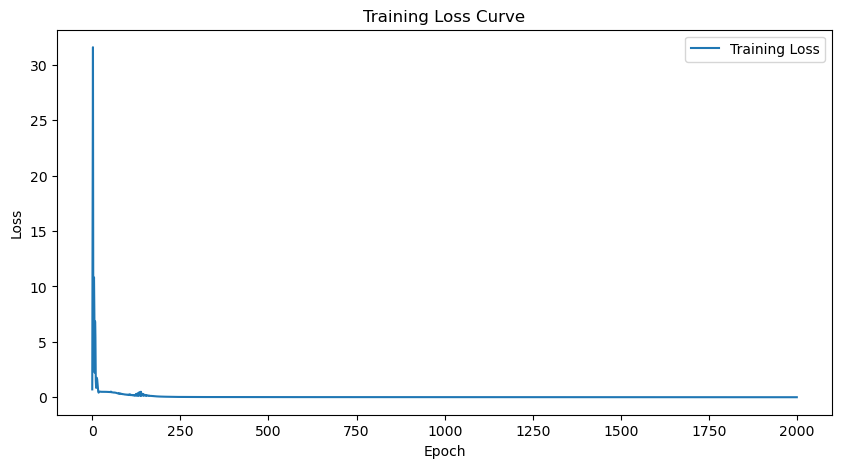

Best Model was saved at epoch 30 with F1-score 0.8265 and accuracy 71.43%


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'.


In [11]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 71.43%
                  precision    recall  f1-score   support

    infringement       0.67      0.11      0.19        36
non_infringement       0.72      0.98      0.83        83

        accuracy                           0.71       119
       macro avg       0.69      0.54      0.51       119
    weighted avg       0.70      0.71      0.63       119



/tmp/ipykernel_84034/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
